# Simplicial Complexes and Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

## Simplicial Homology

#TODO: Exmplain homology

**Question:** What does homology have to do with data analysis?

The idea we will explore is to use the set $X$ to create increasingly complicated simplicial complexes which capture the geometry and topology of $X$ at many scales. To motivate this, let's construct a toy dataset.

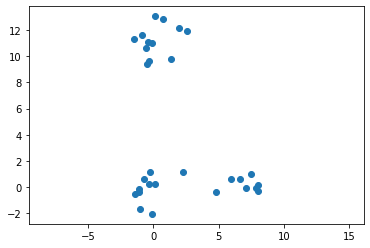

In [2]:
X1 = np.random.multivariate_normal([0,0],np.array([[1,0],[0,1]]),size = 10)
X2 = np.random.multivariate_normal([7,0],np.array([[1,0],[0,0.2]]),size = 8)
X3 = np.random.multivariate_normal([0,11],np.array([[1,0],[0,1]]),size = 12)

X = np.concatenate((X1,X2,X3))

plt.plot(X[:,0],X[:,1],'o')
plt.axis('equal')
plt.show()

## Back to Clustering

Recall that one of our motivations for studying topology in the context of data analysis was overcoming issues with clustering. K-means for example gives a multiscale picture of the clustering structure of the data. But "clusters" are just connected pieces of the data; i.e., elements of $H_0(X)$. Now let's try to make this precise.

## Creating a Growing Simplicial Complex

First we create a distance matrix for $X$.

In [3]:
from sklearn.metrics import pairwise_distances

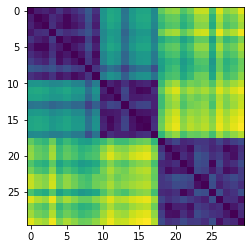

In [4]:
D = pairwise_distances(X)
plt.imshow(D)
plt.show()

In [5]:
def create_simplicial_complex(D,r):
    """
    Input: distance matrix and nonnegative radius
    Output: networkx graph 
    """
    
    G = nx.Graph()
    G.add_nodes_from(list(range(len(D))))
    edge_list = np.argwhere(D <= r) 
    G.add_edges_from(edge_list)
    
    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    return G

Try it out:

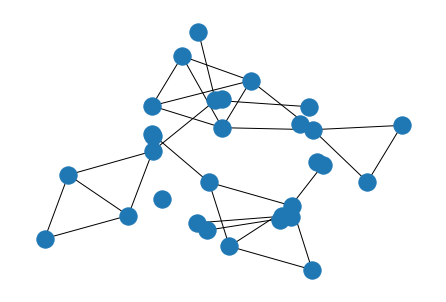

In [6]:
r = 1
G = create_simplicial_complex(D,r)
nx.draw_kamada_kawai(G)

The function works, but we would like our drawings to be more related to the original dataset. We can set node positions in `networkx` graphs.

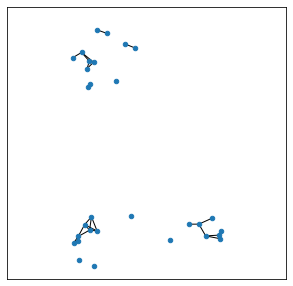

In [7]:
pos = {n:X[n,:] for n in range(len(X))}
plt.figure(figsize = (5,5))
nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 20)
plt.axis('equal')
plt.show()

Now let's look at how this evolves over a few radii:

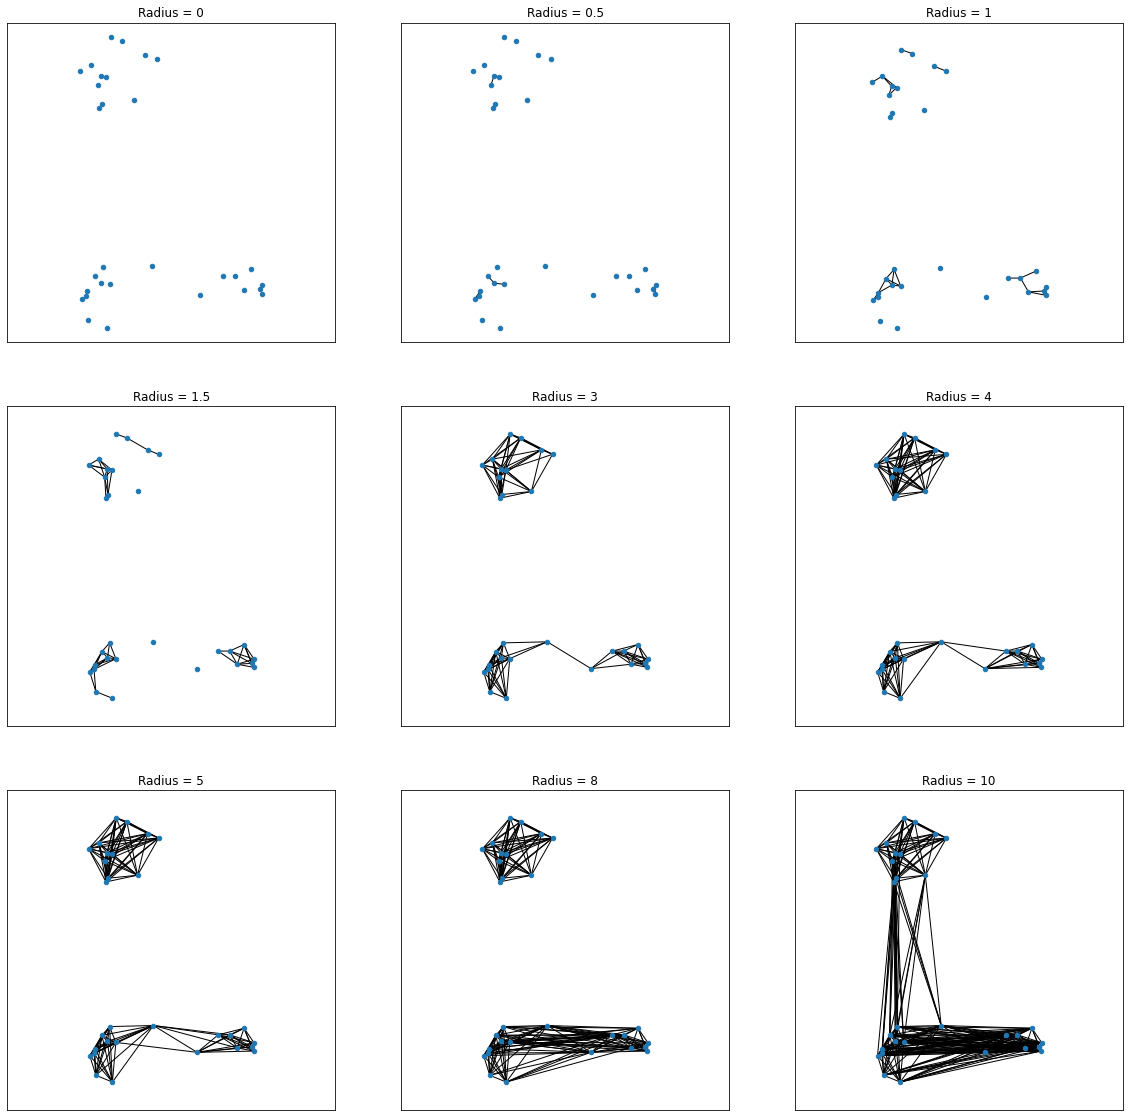

In [8]:
rs = [0,0.5,1,1.5,3,4,5,8,10]

plt.figure(figsize = (20,20))

for (j,r) in enumerate(rs):
    G = create_simplicial_complex(D,r)
    plt.subplot(3,3,j+1)
    nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 20)
    plt.axis('equal')
    plt.title('Radius = '+str(r))

plt.show()

#TODO: 
Observe that the heights where clusters merge correspond to the radii $r$ where the corresponding equivalence classes merge in $H_0(X_r)$. 

## Higher-Dimensional Homology

To see how higher-dimensional homology would come into play, let's look at one more example.

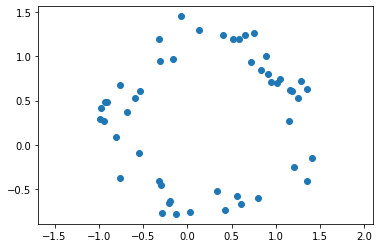

In [9]:
num_points = 50

X = np.random.multivariate_normal([0,0],np.array([[1,0],[0,1]]),size = num_points)
X = X.T/np.linalg.norm(X,axis = 1)
X = X.T + 0.5*np.random.rand(num_points,2)

plt.plot(X[:,0],X[:,1],'o')
plt.axis('equal')
plt.show()

In [10]:
D = pairwise_distances(X)

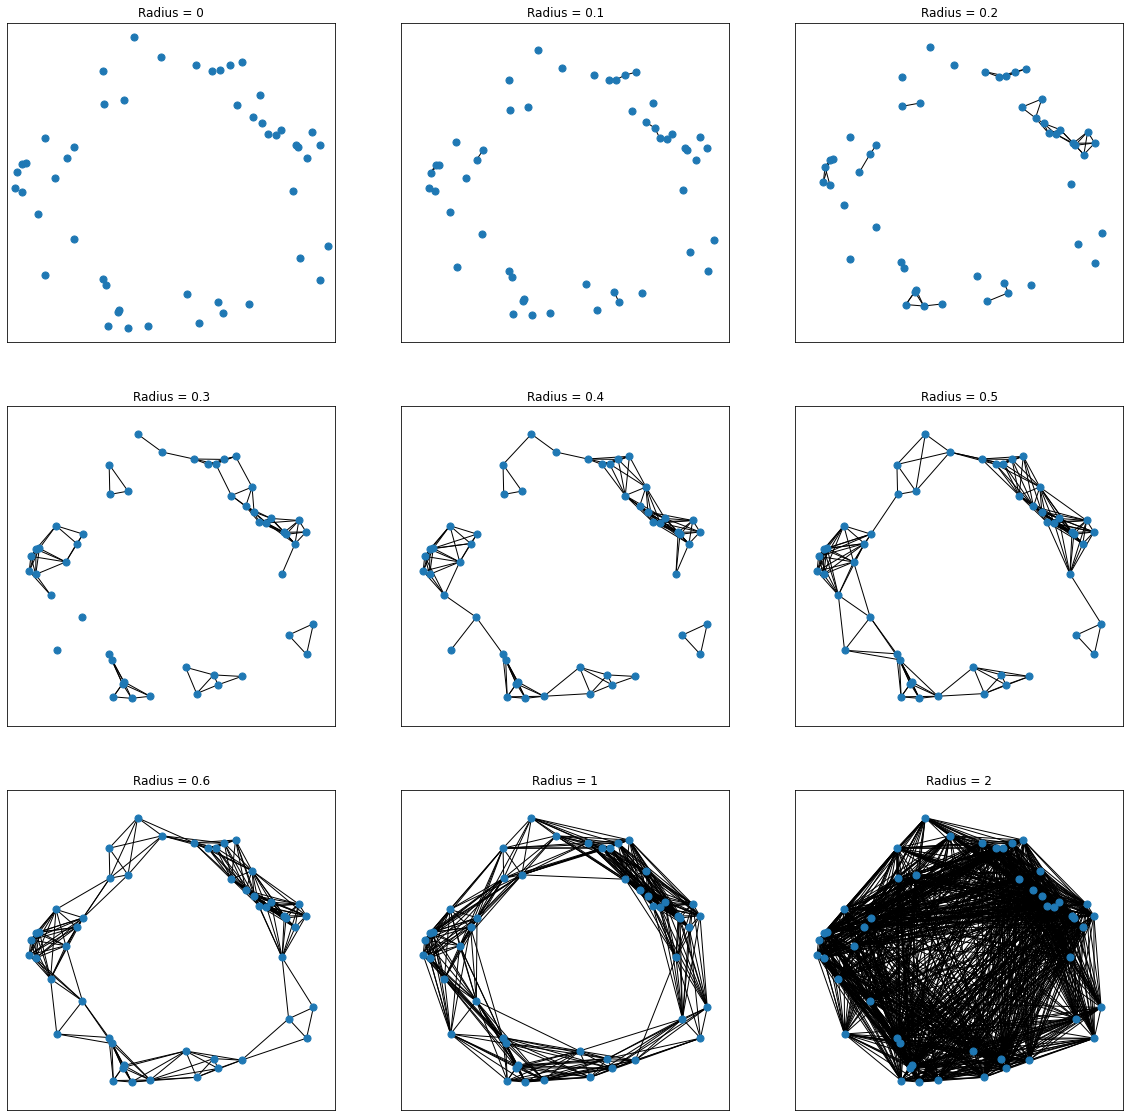

In [11]:
rs = [0,0.1,0.2,0.3,0.4,0.5,0.6,1,2]
pos = {n:X[n,:] for n in range(len(X))}

plt.figure(figsize = (20,20))

for (j,r) in enumerate(rs):
    G = create_simplicial_complex(D,r)
    plt.subplot(3,3,j+1)
    nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 50)
    plt.axis('equal')
    plt.title('Radius = '+str(r))

plt.show()

For this dataset, there is a 'loop structure' which may be of interest. To see it computationally, we would want to track $1$-dimensional homology:

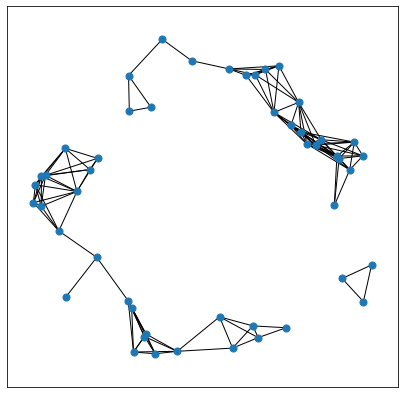

In [12]:
plt.figure(figsize = (7,7))
r = 0.4
G = create_simplicial_complex(D,r)
nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 50)
plt.axis('equal')
plt.show()

In [13]:
def create_2_dim_simplicial_complex(D,r):
    
    # Create 1-skeleton
    G = create_simplicial_complex(D,r)
    
    # Get a list of 2-simplices
    two_spx_list = []
    
    # Naive search for viable 2-simplices
    for edge in G.edges():
        for vertex in G.nodes():
            if vertex != edge[0] and vertex != edge[1] and D[edge[0],vertex] < r and D[edge[1],vertex] < r:
                two_spx_list.append([edge[0],edge[1],vertex])
                
    return G, two_spx_list

In [14]:
G, two_spx_list = create_2_dim_simplicial_complex(D,r)

To draw the simplices, we'll use the `Polygon` function imported above. We'll add the triangles one-by-one to a collection, then use plotting tools to display them.

In [15]:
patches = []

for i,spx in enumerate(two_spx_list):
    position_array = np.array([[pos[vert][0],pos[vert][1]] for vert in spx])
    polygon = Polygon(position_array, True)
    patches.append(polygon)

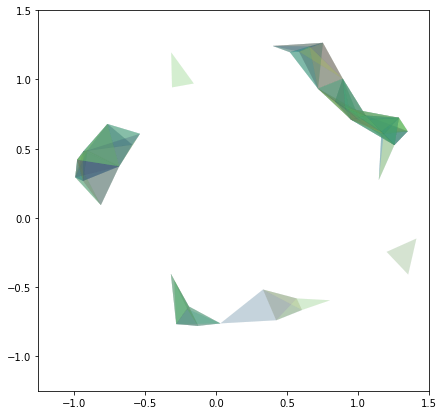

In [16]:
fig, ax = plt.subplots(figsize = (7,7))

colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.1)
p.set_array(np.array(colors))
ax.add_collection(p)

plt.xlim([-1.25, 1.5])
plt.ylim([-1.25, 1.5])
plt.show()

Now we'll plot the 1-skeleton first and overlay the triangles.

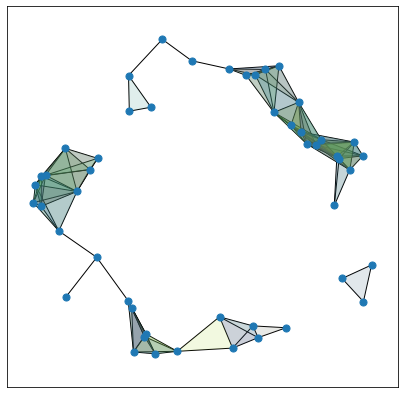

In [17]:
fig, ax = plt.subplots(figsize = (7,7))

nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 50)
colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.05)
p.set_array(np.array(colors))
ax.add_collection(p)

plt.axis('equal')
plt.show()

Looks good! Now let's run it on a range of radii. 

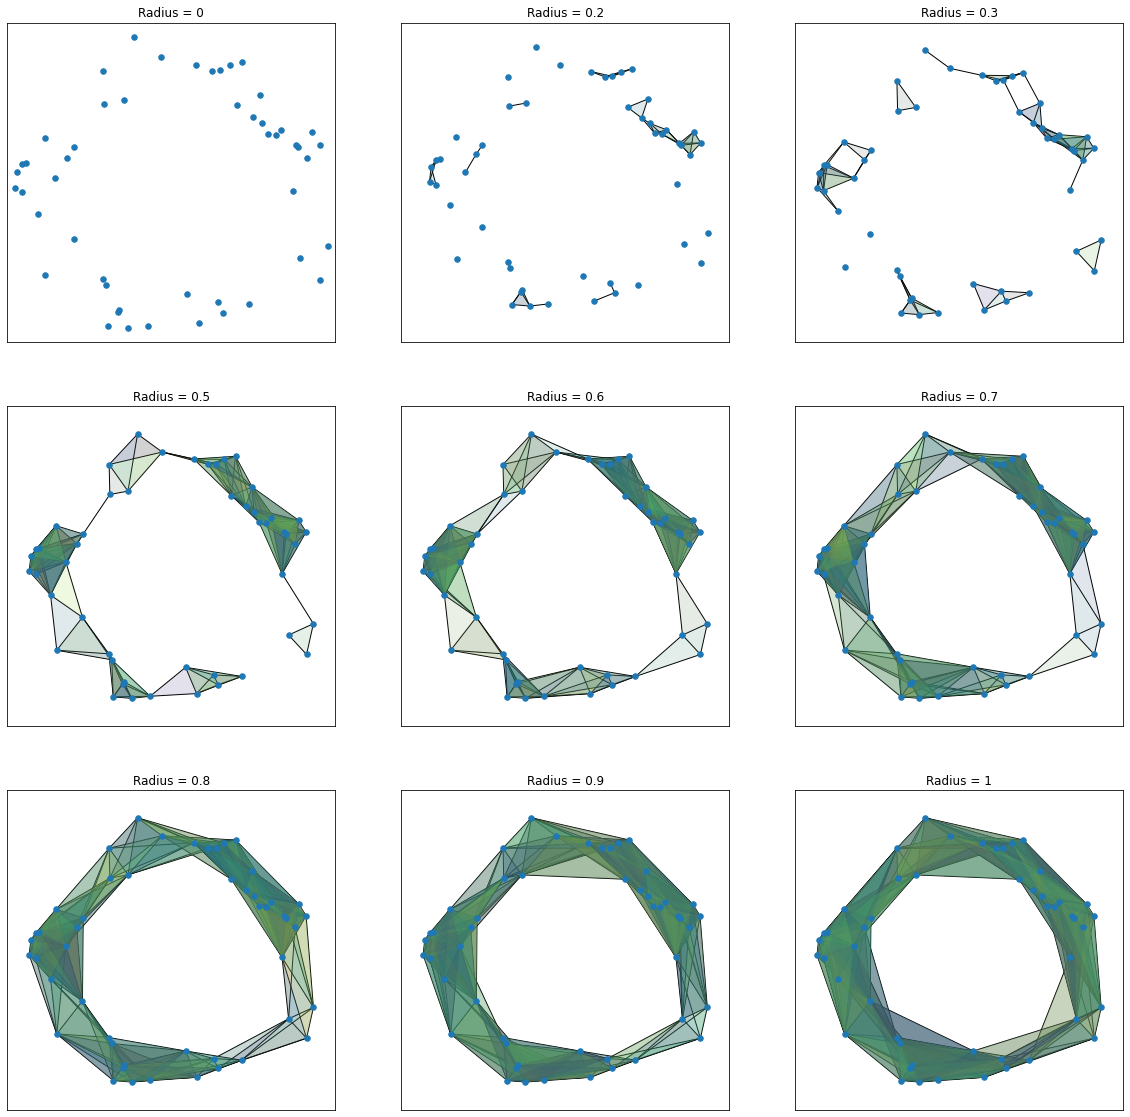

In [18]:
rs = [0,0.2,0.3,0.5,0.6,0.7,0.8,0.9,1]
pos = {n:X[n,:] for n in range(len(X))}

plt.figure(figsize = (20,20))

for (j,r) in enumerate(rs):
    G, two_spx_list = create_2_dim_simplicial_complex(D,r)
    patches = []

    for i,spx in enumerate(two_spx_list):
        position_array = np.array([[pos[vert][0],pos[vert][1]] for vert in spx])
        polygon = Polygon(position_array, True)
        patches.append(polygon)
        
    ax = plt.subplot(3,3,j+1)
    nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 30)
    colors = 100*np.random.rand(len(patches))
    p = PatchCollection(patches, alpha=0.05)
    p.set_array(np.array(colors))
    ax.add_collection(p)
    
    plt.axis('equal')
    plt.title('Radius = '+str(r))

plt.show()

We see that loops appear in the data:
- small loops appear earlier in the process but are quickly filled in
- a much stronger loop appears a bit later but persists for a long time
- the large loop will also eventually be filled in, but the idea is that keep track of how features change over 'filtration values' (values of $r$).

## Persistent Homology

**Question:** How can a persistence module be used in practice?

That is, we need ways to 
- conveniently represent and visualize persistence modules, and
- compare persistence modules coming from different datasets.

## Persistence Diagrams and Barcodes

To address the first part of the question, here is some code which can be used to represent/visualize persistence modules.

We'll use a TDA package called `gudhi`. Documentation for the package is here: http://gudhi.gforge.inria.fr.

In [19]:
pip install gudhi

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\herna\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [20]:
import gudhi as gd

Let's first study the dataset that we were looking at above. In `gudhi`, we create the simplicial complex using the following functions.

In [21]:
skeleton = gd.RipsComplex(distance_matrix = D, max_edge_length = 2) 
Rips_complex = skeleton.create_simplex_tree(max_dimension = 2)

The VR complex is stored as a simplicial complex, together with a 'filtration' value for the simplex. This is the radius at which the simplex first appears in $\mathrm{VR}_r(X)$. 

Let's see how many simplices there are and print off the first couple of hundred to see what the structure looks like.

In [22]:
rips_filtration = Rips_complex.get_filtration()
rips_list = list(rips_filtration)
print('Number of Simplices:',len(rips_list))
for splx in rips_list[0:200] :
    print(splx)

Number of Simplices: 14327
([0], 0.0)
([1], 0.0)
([2], 0.0)
([3], 0.0)
([4], 0.0)
([5], 0.0)
([6], 0.0)
([7], 0.0)
([8], 0.0)
([9], 0.0)
([10], 0.0)
([11], 0.0)
([12], 0.0)
([13], 0.0)
([14], 0.0)
([15], 0.0)
([16], 0.0)
([17], 0.0)
([18], 0.0)
([19], 0.0)
([20], 0.0)
([21], 0.0)
([22], 0.0)
([23], 0.0)
([24], 0.0)
([25], 0.0)
([26], 0.0)
([27], 0.0)
([28], 0.0)
([29], 0.0)
([30], 0.0)
([31], 0.0)
([32], 0.0)
([33], 0.0)
([34], 0.0)
([35], 0.0)
([36], 0.0)
([37], 0.0)
([38], 0.0)
([39], 0.0)
([40], 0.0)
([41], 0.0)
([42], 0.0)
([43], 0.0)
([44], 0.0)
([45], 0.0)
([46], 0.0)
([47], 0.0)
([48], 0.0)
([49], 0.0)
([22, 48], 0.021243967086407984)
([4, 21], 0.023489904019234713)
([33, 40], 0.029673559520717784)
([17, 39], 0.05456359801715293)
([6, 9], 0.05609083307733875)
([5, 8], 0.060858443419517884)
([17, 38], 0.06355421655107121)
([19, 30], 0.06491258096328978)
([33, 37], 0.07447992792680497)
([19, 26], 0.0815518156519583)
([41, 46], 0.08472565652357981)
([34, 45], 0.09153375115109492)
(

Okay... so now we have a complex. But what do we do with it? The following code computes the persistence module for the complex and represents it in a particular way.

In [23]:
BarCodes = Rips_complex.persistence()

Looking at the result...

In [24]:
BarCodes

[(1, (0.5296250857762669, 1.4513204472106527)),
 (1, (0.2511653146959418, 0.3169377317895405)),
 (1, (0.2982829836778893, 0.33160053502770687)),
 (1, (0.4388323048306811, 0.46028207325989545)),
 (1, (0.15819634911066802, 0.16994691830927056)),
 (0, (0.0, inf)),
 (0, (0.0, 0.4985952275361504)),
 (0, (0.0, 0.4038721115433361)),
 (0, (0.0, 0.38736583445000256)),
 (0, (0.0, 0.38100493120847573)),
 (0, (0.0, 0.3530742667058793)),
 (0, (0.0, 0.35195310700936966)),
 (0, (0.0, 0.3283756285844772)),
 (0, (0.0, 0.2949967922517334)),
 (0, (0.0, 0.27567380123457863)),
 (0, (0.0, 0.2738086907512605)),
 (0, (0.0, 0.25766088066129306)),
 (0, (0.0, 0.25311122217102655)),
 (0, (0.0, 0.24073757760331374)),
 (0, (0.0, 0.2371945610321908)),
 (0, (0.0, 0.2304249671337657)),
 (0, (0.0, 0.23013962376023395)),
 (0, (0.0, 0.22325374790909508)),
 (0, (0.0, 0.2152008609529555)),
 (0, (0.0, 0.21154551641565228)),
 (0, (0.0, 0.21067583834068213)),
 (0, (0.0, 0.19604457580042903)),
 (0, (0.0, 0.18084728854319326)),

So it's a bunch of things of the form $(d,(x,y))$. We can plot these things in a couple of ways. Let's see if we can guess what this representation is telling us about the data.

The following is called a *persistence diagram*.

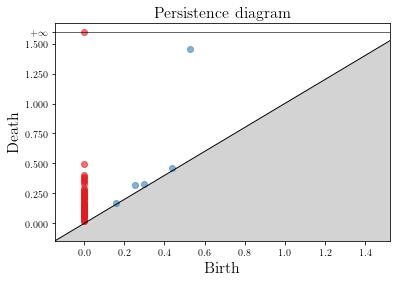

In [25]:
gd.plot_persistence_diagram(BarCodes)
plt.show()

The following is called a *barcode representation*.

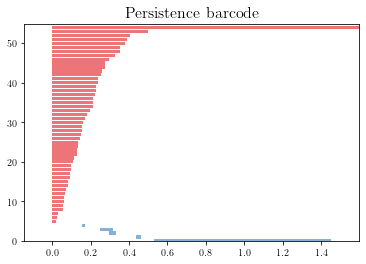

In [26]:
gd.plot_persistence_barcode(BarCodes)
plt.show()

Any guesses for what this represents?

## Another Example

Let's run this pipeline on one more example to get an intuitive feel for how it works.

## Next Steps

Our plan is to precisely understand what the points in the persistence diagram/bars in the barcodes represent. 

## Exercise

Try running through this pipeline for other point clouds; either toy datasets of your own design, toy datasets from, say, `scikit-learn`, or a real world dataset.